In [1]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm
from boto3.s3.transfer import TransferConfig
import boto3
from rasterio.session import AWSSession
from pathlib import Path

# Get AWS Session

In [2]:
session = boto3.session.Session(profile_name='saml-pub')
s3 = session.resource('s3')

# Get Metadata for Hansen Tiles in GeoDataFrame

In [3]:
obj = s3.Object('calval-metadata', 'test-hansen-landsat.geojson')
obj.get()

{'ResponseMetadata': {'RequestId': '20D4QNKYA59E7N4H',
  'HostId': 'tr3nqs0abmtONprb6nKvKhmuvlB32H2smD8Qjf8fGza/5pNUhLGN9vTN7CAU9jXR7ncWxtvd3zg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'tr3nqs0abmtONprb6nKvKhmuvlB32H2smD8Qjf8fGza/5pNUhLGN9vTN7CAU9jXR7ncWxtvd3zg=',
   'x-amz-request-id': '20D4QNKYA59E7N4H',
   'date': 'Wed, 22 Dec 2021 17:35:58 GMT',
   'last-modified': 'Mon, 20 Dec 2021 19:40:20 GMT',
   'etag': '"52a1e9c4d64a172ee02c47da3bf63dea"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '845'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 12, 20, 19, 40, 20, tzinfo=tzutc()),
 'ContentLength': 845,
 'ETag': '"52a1e9c4d64a172ee02c47da3bf63dea"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f990780bca0>}

<AxesSubplot:>

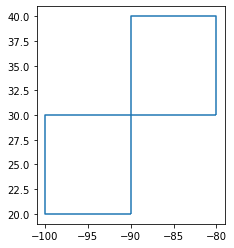

In [4]:
data = obj.get()['Body']
df_delta_tiles = gpd.read_file(data)
df_delta_tiles.exterior.plot()

In [5]:
df_delta_tiles

,bucket,key,source_url,year,geometry
0,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-90.00000 20.00000, -90.00000 30.000..."
1,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-80.00000 30.00000, -80.00000 40.000..."


In [6]:
records = df_delta_tiles.to_dict('records')

# Create a "Local" Bucket

In [7]:
out_dir = records[0]['bucket']
out_dir_path = Path(out_dir)
out_dir_path.mkdir(exist_ok=True)

# Read Data with Rasterio (Example)

It's negligible on a fast server.

The buckets have to be unique globally - interesting that this is harder than it seems and will throw an [error](https://stackoverflow.com/q/57146311) like this.

In [8]:
record = records[0]

Reference is this [issue ticket](https://github.com/rasterio/rasterio/issues/1507)

In [9]:
bucket = record['bucket']
key = record['key']

with rasterio.Env(AWSSession(session)):
    with rasterio.open(f's3://{bucket}/{key}') as ds:
        profile = ds.profile
        
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40000, 'height': 40000, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -100.0,
       0.0, -0.00025, 30.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

Reading the image should take some time. So we are going to avoid it.

In [10]:
# %%time

# bucket = record['bucket']
# key = record['key']

# with rasterio.Env(AWSSession(session)):
#     with rasterio.open(f's3://{bucket}/{key}') as ds:
#         X = ds.read()

Let's use `boto3` built in multithreading.

In [11]:
obj = s3.Object(bucket, key)
resp = obj.get()
resp

{'ResponseMetadata': {'RequestId': 'KEV3J5DXT7DKTCA7',
  'HostId': 'XMj9MV8Wm9aoHNENElfEDeWMlOLGHrzPBXw7V5yZ6qPz2QSssS3xxYUOeKjGMyf7O4sSKq6UnEI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'XMj9MV8Wm9aoHNENElfEDeWMlOLGHrzPBXw7V5yZ6qPz2QSssS3xxYUOeKjGMyf7O4sSKq6UnEI=',
   'x-amz-request-id': 'KEV3J5DXT7DKTCA7',
   'date': 'Wed, 22 Dec 2021 17:35:59 GMT',
   'last-modified': 'Tue, 21 Dec 2021 22:34:17 GMT',
   'etag': '"b3a6bc762b3c59365ce2016e1a787173-599"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '5022295203'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 12, 21, 22, 34, 17, tzinfo=tzutc()),
 'ContentLength': 5022295203,
 'ETag': '"b3a6bc762b3c59365ce2016e1a787173-599"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f98ff48a620>}

Some [notes](https://stackoverflow.com/questions/57868574/different-between-download-file-and-download-fileobj-in-boto3) about different ways to download files.

In [13]:
obj = s3.Object(bucket, key)
resp = obj.get()

total_size = resp['ContentLength']
config = TransferConfig(multipart_threshold=1024, 
                        max_concurrency=30, 
                        use_threads=True)
with tqdm(total=total_size,  
          unit='B', 
          unit_scale=True, 
          unit_divisor=1024) as pbar:

    s3.meta.client.download_file(bucket, key, str(out_dir_path / key), Config=config, Callback=pbar.update)

100%|█████████████████████████████████████████████████| 4.68G/4.68G [00:24<00:00, 209MB/s]


In [14]:
%%time

with rasterio.open(key) as ds:
    X = ds.read()
X.shape

CPU times: user 21.8 s, sys: 4.8 s, total: 26.6 s
Wall time: 26.7 s


(4, 40000, 40000)

In [15]:
image = X.transpose([1, 2, 0])

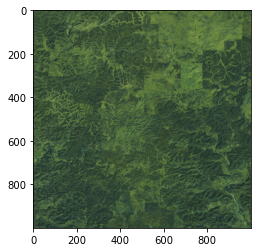

In [16]:
plt.imshow(image[:1_000, :1_000, [3, 2, 1]])

# Automate

In [17]:
records

[{'bucket': 'test-calval-hansen-mosaics-2020',
  'key': 'Hansen_GFC-2020-v1.8_last_30N_100W.tif',
  'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
  'year': 2020,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7f990780bfa0>},
 {'bucket': 'test-calval-hansen-mosaics-2020',
  'key': 'Hansen_GFC-2020-v1.8_last_40N_090W.tif',
  'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif',
  'year': 2020,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7f990780bf70>}]

In [18]:
def download_record(record):
    
    
    bucket = record['bucket']
    key = record['key']

    obj = s3.Object(bucket, key)
    resp = obj.get()

    total_size = resp['ContentLength']
    config = TransferConfig(multipart_threshold=1024, 
                            max_concurrency=30, 
                            use_threads=True)
    with tqdm(total=total_size,  
              unit='B', 
              unit_scale=True, 
              unit_divisor=1024,
              desc=key) as pbar:
        out_path = out_dir_path / key
        s3.meta.client.download_file(bucket, key, str(out_path), Config=config, Callback=pbar.update)
    return out_path

In [19]:
results = list(map(download_record, records))
results

Hansen_GFC-2020-v1.8_last_30N_100W.tif: 100%|█████████| 4.68G/4.68G [00:25<00:00, 198MB/s]
Hansen_GFC-2020-v1.8_last_40N_090W.tif: 100%|█████████| 12.3G/12.3G [01:01<00:00, 214MB/s]


[PosixPath('test-calval-hansen-mosaics-2020/Hansen_GFC-2020-v1.8_last_30N_100W.tif'),
 PosixPath('test-calval-hansen-mosaics-2020/Hansen_GFC-2020-v1.8_last_40N_090W.tif')]

# Verify Tiles Match with Image

In [20]:
from shapely.geometry import box, Polygon
from rasterio.crs import CRS

def get_extents_bbox(path: Path) -> Polygon:
    with rasterio.open(path) as ds:
        bounds = list(ds.bounds)
    return box(*bounds)

geometry = list(map(get_extents_bbox, results))

df_extent_tifs = gpd.GeoDataFrame(geometry=geometry, crs=CRS.from_epsg(4326))

<AxesSubplot:>

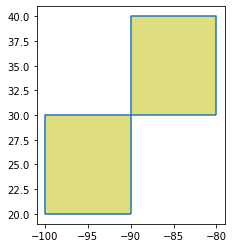

In [21]:
fig, ax = plt.subplots()

df_extent_tifs.plot(ax=ax, alpha=.5, color='y')
df_delta_tiles.exterior.plot(ax=ax)